In [2]:
import os
import random
import sys
import numpy as np
from PIL import Image
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import librosa
import librosa.display

import torch
import torchvision
import torchaudio
import torchaudio.transforms as T




In [3]:
print("PyTorch Version: " + torch.__version__)
print("Cuda: " + str(torch.cuda.is_available()))
print("Torchvision Version: " + torchvision.__version__)
print("Torchaudio Version: " + torchaudio.__version__)

PyTorch Version: 1.9.1+cu111
Cuda: True
Torchvision Version: 0.10.1+cu111
Torchaudio Version: 0.9.1


In [4]:
data_path = "../data"
normal_example = os.path.join(data_path, 'pump', 'id_00', 'normal', '00000000.wav')
abnormal_example = os.path.join(data_path, 'pump', 'id_00', 'abnormal', '00000000.wav')

In [5]:
normal_audio_signal, sample_rate = torchaudio.load(normal_example)
abnormal_audio_signal, sample_rate= torchaudio.load(abnormal_example)

In [6]:
#function from torchaudio examples
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

In [7]:
print_stats(normal_audio_signal, sample_rate=sample_rate)

Sample Rate: 16000
Shape: (8, 160000)
Dtype: torch.float32
 - Max:      0.091
 - Min:     -0.084
 - Mean:    -0.000
 - Std Dev:  0.012

tensor([[ 0.0137,  0.0059, -0.0037,  ..., -0.0046,  0.0170,  0.0174],
        [ 0.0114,  0.0038,  0.0015,  ...,  0.0103,  0.0238,  0.0157],
        [ 0.0011,  0.0106,  0.0178,  ...,  0.0143,  0.0243,  0.0145],
        ...,
        [-0.0119, -0.0035,  0.0280,  ...,  0.0027, -0.0020, -0.0016],
        [ 0.0099, -0.0003,  0.0074,  ...,  0.0068, -0.0022, -0.0009],
        [ 0.0106,  0.0116, -0.0031,  ..., -0.0065, -0.0004,  0.0171]])



In [8]:
print_stats(abnormal_audio_signal, sample_rate=sample_rate)

Sample Rate: 16000
Shape: (8, 160000)
Dtype: torch.float32
 - Max:      0.127
 - Min:     -0.116
 - Mean:    -0.000
 - Std Dev:  0.014

tensor([[-0.0153, -0.0145, -0.0093,  ..., -0.0206, -0.0129, -0.0064],
        [-0.0193, -0.0099, -0.0094,  ..., -0.0116, -0.0132, -0.0030],
        [-0.0126, -0.0061, -0.0077,  ...,  0.0007, -0.0031, -0.0053],
        ...,
        [-0.0082, -0.0106, -0.0106,  ..., -0.0153, -0.0090, -0.0069],
        [-0.0123, -0.0076, -0.0062,  ..., -0.0189, -0.0156, -0.0070],
        [-0.0125, -0.0112, -0.0099,  ..., -0.0215, -0.0143, -0.0013]])



C:\Users\tomih\AppData\Local\Programs\Python\Python38\lib\site-packages\librosa\util\utils.py:198: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  warnings.warn(


Text(0.5, 1.0, 'Normal and Abnormal Sound Signal')

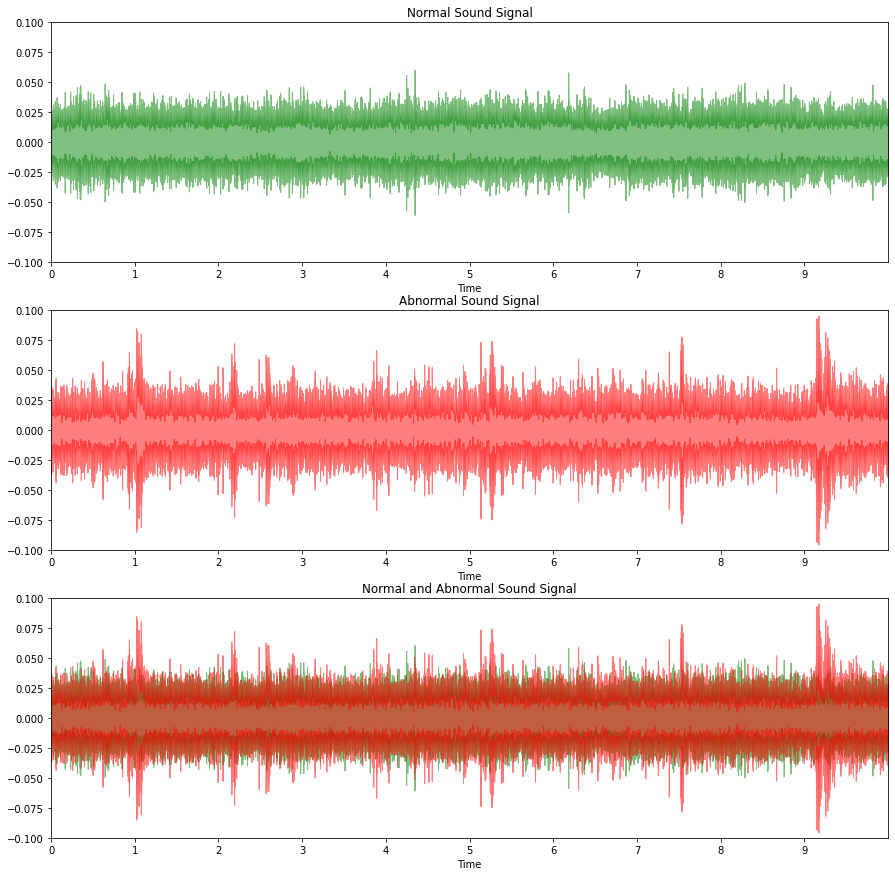

In [9]:
fig = plt.figure(figsize=(15, 15))

#normal signal
ax1 = plt.subplot(3,1,1)
ax1.set_ylim([-0.1,0.1])
librosa.display.waveplot(normal_audio_signal[0].cpu().detach().numpy(), sr = sample_rate, alpha = 0.5, color="green")
plt.title('Normal Sound Signal')
#abnormal signal
ax2 = plt.subplot(3,1,2)
ax2.set_ylim([-0.1,0.1])
librosa.display.waveplot(abnormal_audio_signal[0].cpu().detach().numpy(), sr=sample_rate, alpha=0.5, color="red")
plt.title('Abnormal Sound Signal')
#both signals together
ax3 = plt.subplot(3,1,3)
ax3.set_ylim([-0.1,0.1])
librosa.display.waveplot(normal_audio_signal[0].cpu().detach().numpy(), sr=sample_rate, alpha=0.5, color="green", label='Abnormal signal')
librosa.display.waveplot(abnormal_audio_signal[0].cpu().detach().numpy(), sr=sample_rate, alpha=0.5, color="red", label='Normal signal')
plt.title('Normal and Abnormal Sound Signal')

# Generate Mel Spectogram

## First: torchaudio

In [10]:
# Parameters
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm='slaney',
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec_normal = mel_spectrogram(normal_audio_signal)
melspec_abnormal = mel_spectrogram(abnormal_audio_signal)

In [11]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

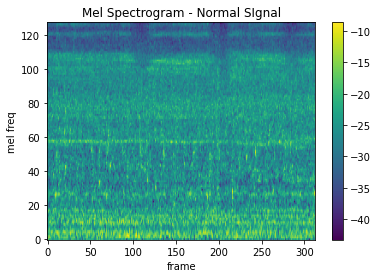

In [12]:
plot_spectrogram(
    melspec_normal[0], title="Mel Spectrogram - Normal SIgnal", ylabel='mel freq')

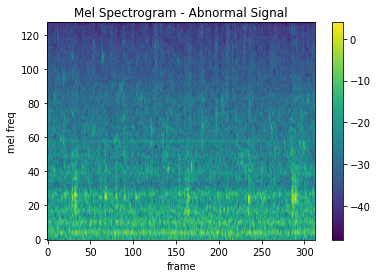

In [13]:
plot_spectrogram(
    melspec_abnormal[0], title="Mel Spectrogram - Abnormal Signal", ylabel='mel freq')